## Confidentiality

This notebook is downloaded from Quantopian and is for demonstrational purposes only.

Please do not copy or distribute this notebook.

## Introduction

This notebook can't be run in Google Colab and should be run in Quantopian Research and Quantopian IDE.


# Advanced Alphalens concepts

Now the basics of Alphalens are covered. Here the following advanced Alphalens concepts are described:

1. Determining an alpha factor's decay rate.
2. Dealing with a common Alphalens error named MaxLossExceededError.
3. Grouping assets by sector, then analyzing each sector individually.
4. Writing group neutral strategies.


In [ ]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import factset
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.classifiers.fundamentals import Sector
from alphalens.utils import get_clean_factor_and_forward_returns


def make_pipeline():
    
    change_in_working_capital = factset.Fundamentals.wkcap_chg_qf.latest
    ciwc_processed = change_in_working_capital.winsorize(.2, .98).zscore()
    
    sales_per_working_capital = factset.Fundamentals.sales_wkcap_qf.latest
    spwc_processed = sales_per_working_capital.winsorize(.2, .98).zscore()

    factor_to_analyze = (ciwc_processed + spwc_processed).zscore()

    sector = Sector()

    return Pipeline(
        columns = {
            'factor_to_analyze': factor_to_analyze,
            'sector': sector,
        },
        screen = (
            QTradableStocksUS()
            & factor_to_analyze.notnull()
            & sector.notnull()
        )
    )


pipeline_output = run_pipeline(make_pipeline(), '2013-1-1', '2014-1-1')
pricing_data = get_pricing(pipeline_output.index.levels[1], '2013-1-1', '2014-3-1', fields='open_price')


factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['factor_to_analyze'], # How to analyze a specific pipeline column with Alphalens
    pricing_data, 
    periods=range(1,32,3)
)

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Analyzing Alpha Factors By Group

Alphalens allows you to group assets using a classifier. A common use case for this is creating a classifier that specifies which sector each equity belongs to, then comparing the alpha factor's returns among sectors.

Assets can be grouped by any classifier, but sector is most common. The Pipeline in the first cell returned a column named `sector`, whose values represent the corresponding Morningstar sector code. All you have to do now is pass that column to the `groupby` argument of `get_clean_factor_and_forward_returns()`

Running the following cell, presents how the factor performs in different sectors.

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D
Ann. alpha,0.043,0.036,0.023
beta,-0.090,-0.093,-0.069
Mean Period Wise Return Top Quantile (bps),0.518,0.178,-0.108
Mean Period Wise Return Bottom Quantile (bps),-1.296,-1.096,-1.261
Mean Period Wise Spread (bps),1.814,1.267,1.143


<Figure size 1008x576 with 0 Axes>

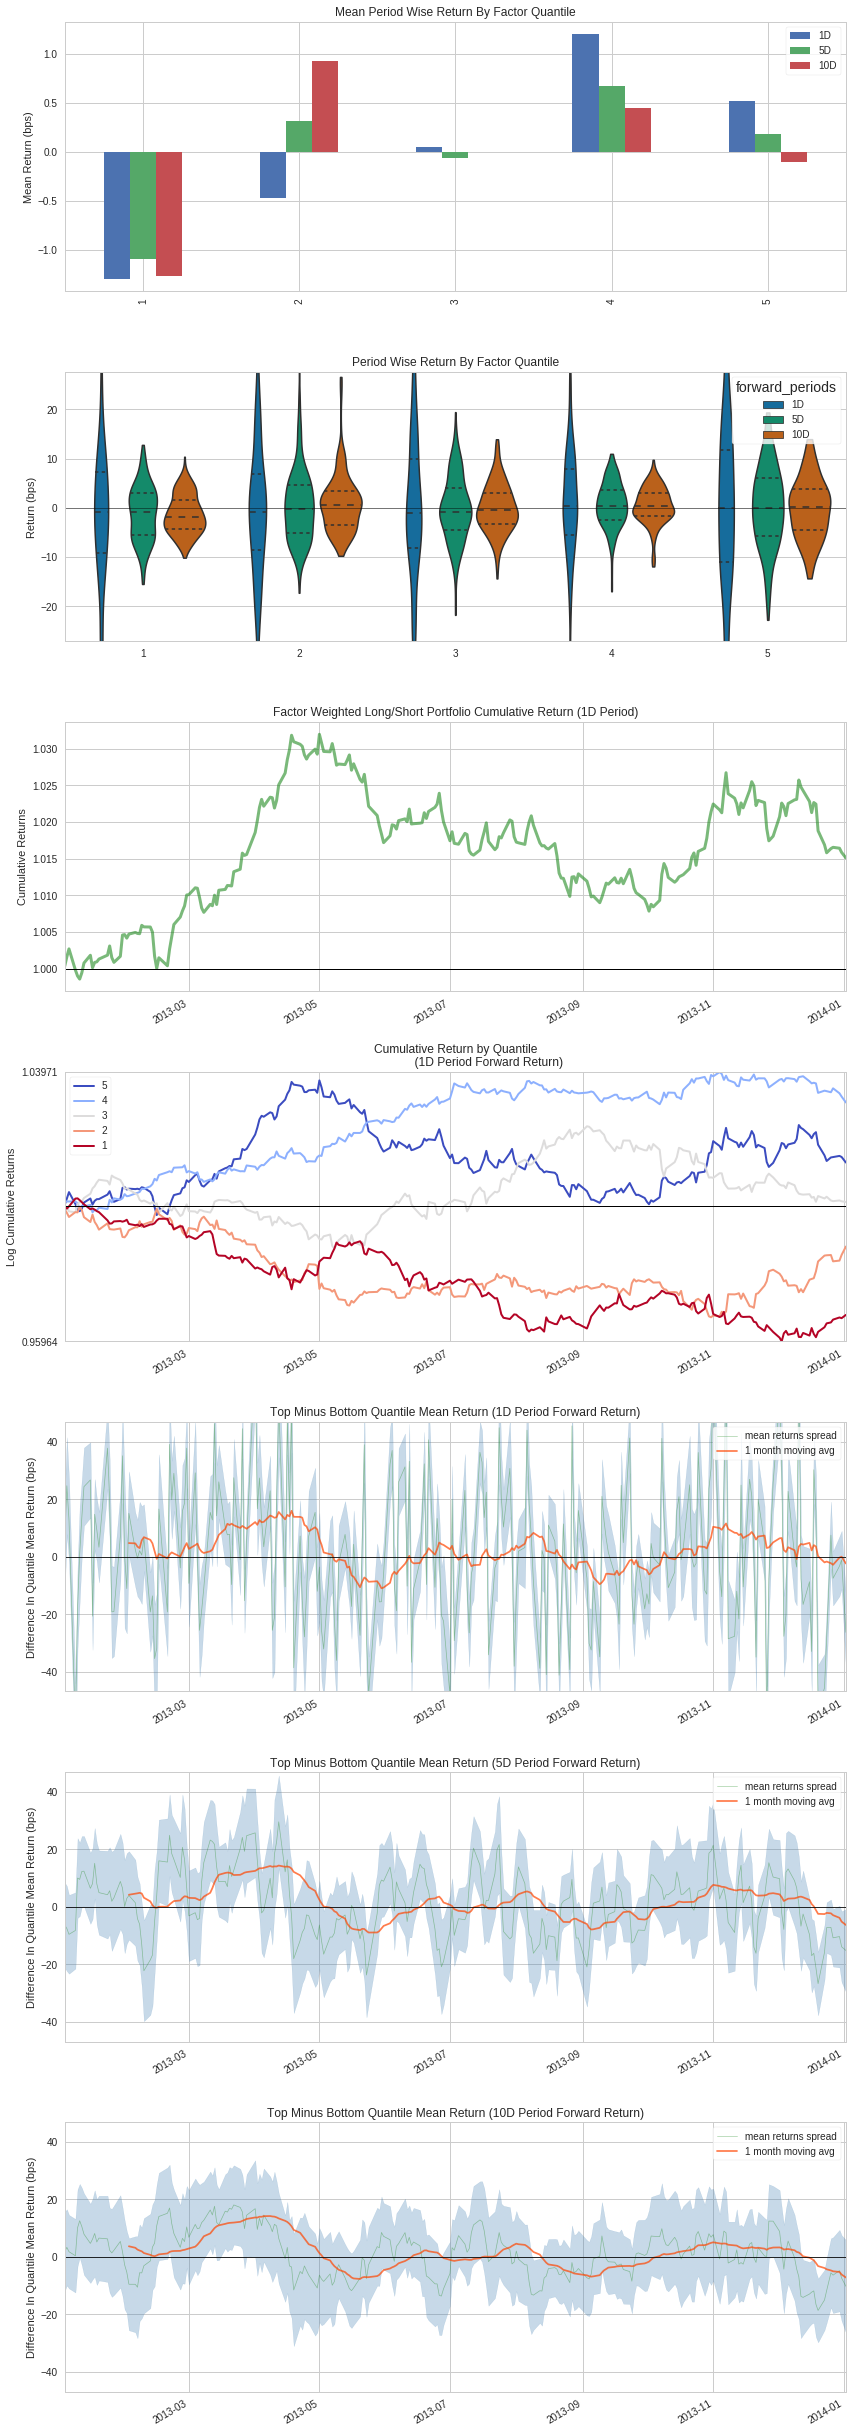

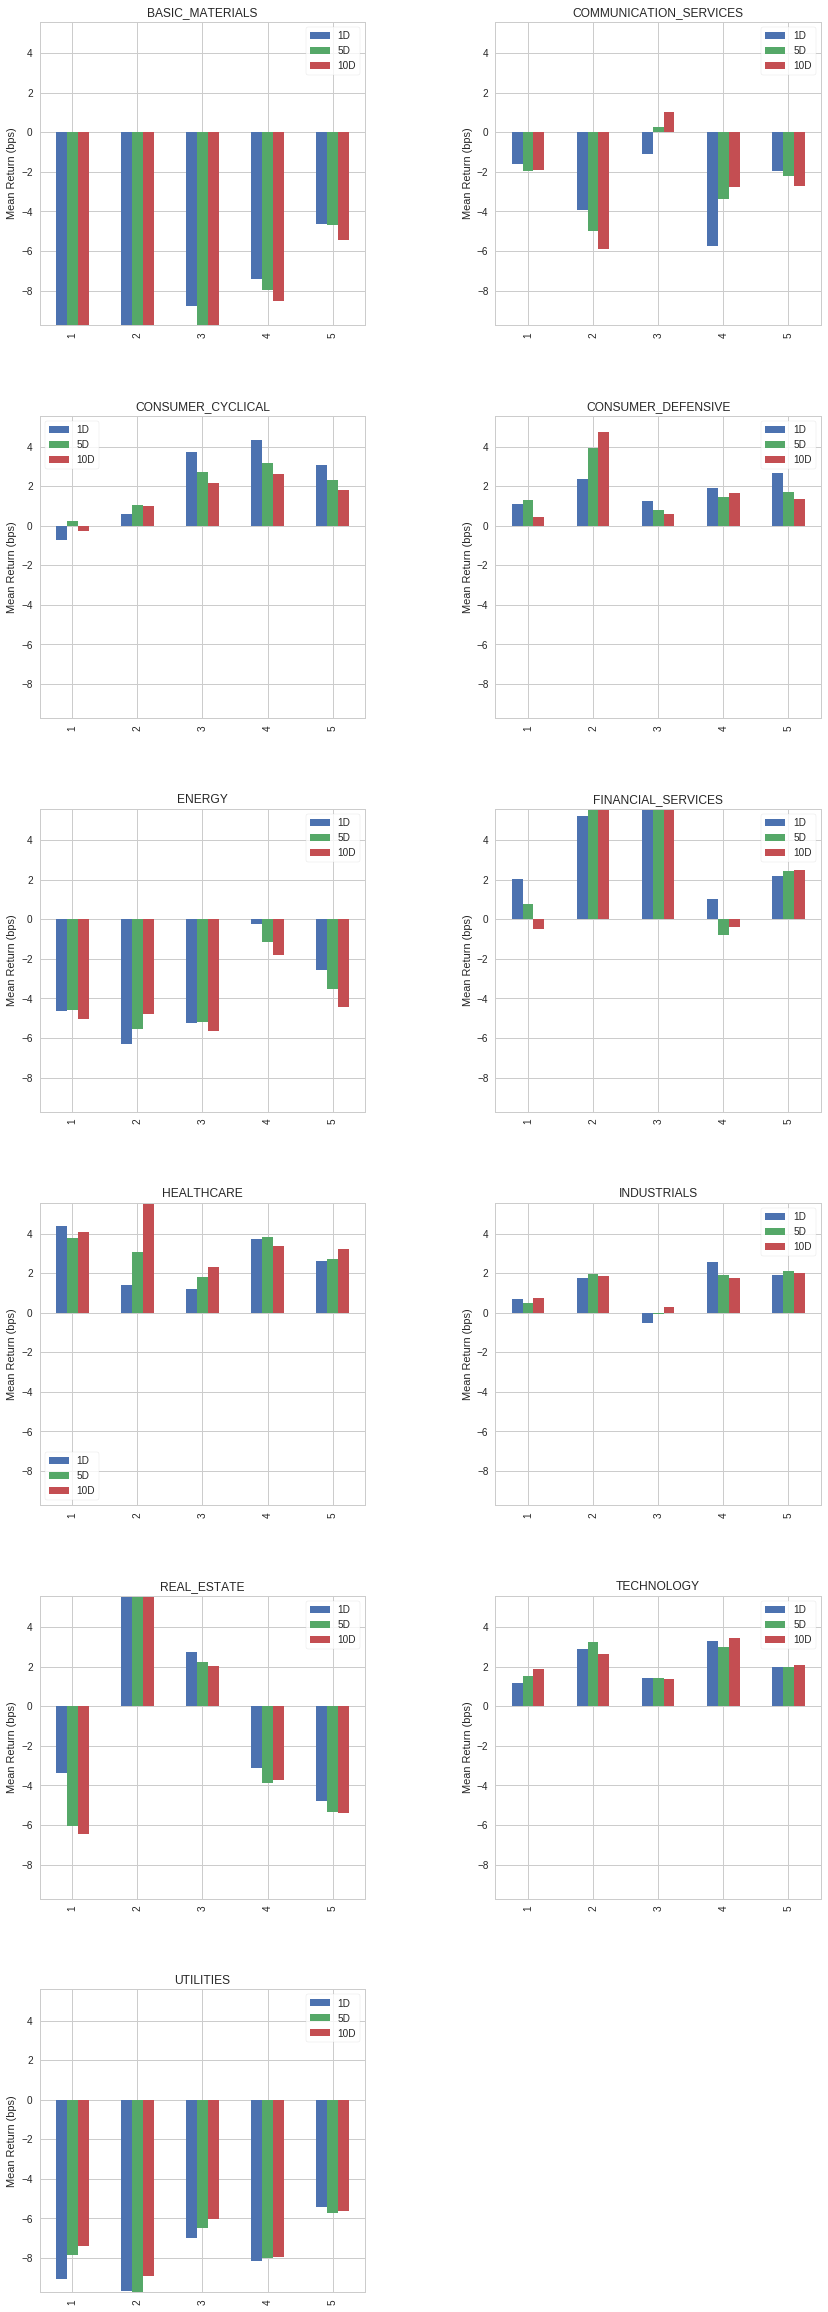

In [ ]:
from alphalens.tears import create_returns_tear_sheet

sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

factor_data = get_clean_factor_and_forward_returns(
    factor=pipeline_output['factor_to_analyze'],
    prices=pricing_data,
    groupby=pipeline_output['sector'],
    groupby_labels=sector_labels,
)

create_returns_tear_sheet(factor_data=factor_data, by_group=True)

## Writing Group Neutral Strategies

Not only does Alphalens allow to simulate how an alpha factor performs in a long/short trading strategy, it also allows to simulate how it would do if you went long/short on every group! 

Grouping by sector, and going long/short on each sector allows you to limit exposure to the overall movement of sectors. For example, you may have noticed, that certain sectors had all positive returns, or all negative returns. That information isn't useful, because it just means the sector group outperformed (or underperformed) the market; it doesn't give any insight into how the factor performs within the specific sector.

Since assets were grouped by sector in the previous cell, going group neutral is easy; just make the two following changes:
- Pass `binning_by_group=True` as an argument to `get_clean_factor_and_forward_returns()`.
- Pass `group_neutral=True` as an argument to `create_full_tear_sheet()`.

Notice how the results differ from the previous cell.

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D
Ann. alpha,0.040,0.036,0.029
beta,-0.072,-0.079,-0.069
Mean Period Wise Return Top Quantile (bps),0.714,0.588,0.305
Mean Period Wise Return Bottom Quantile (bps),-1.969,-1.664,-1.588
Mean Period Wise Spread (bps),2.683,2.251,1.891


<Figure size 1008x576 with 0 Axes>

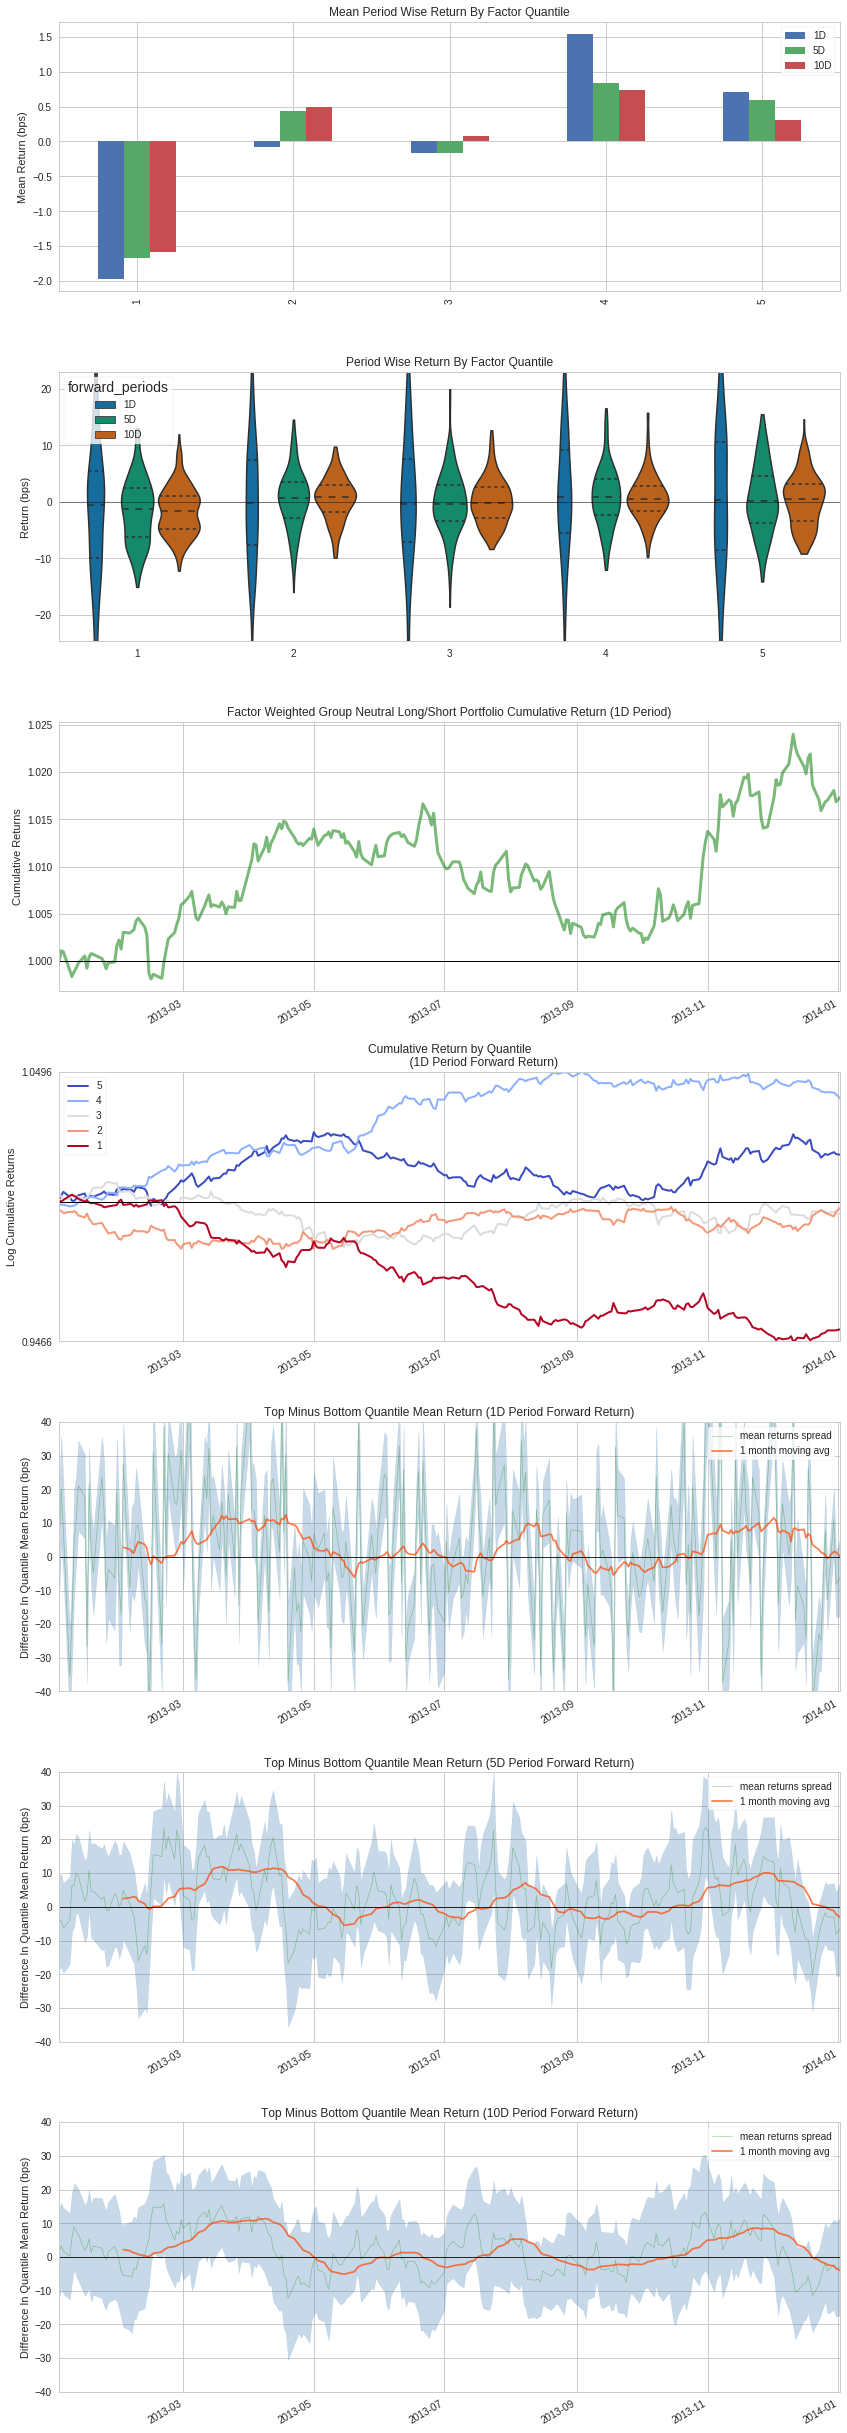

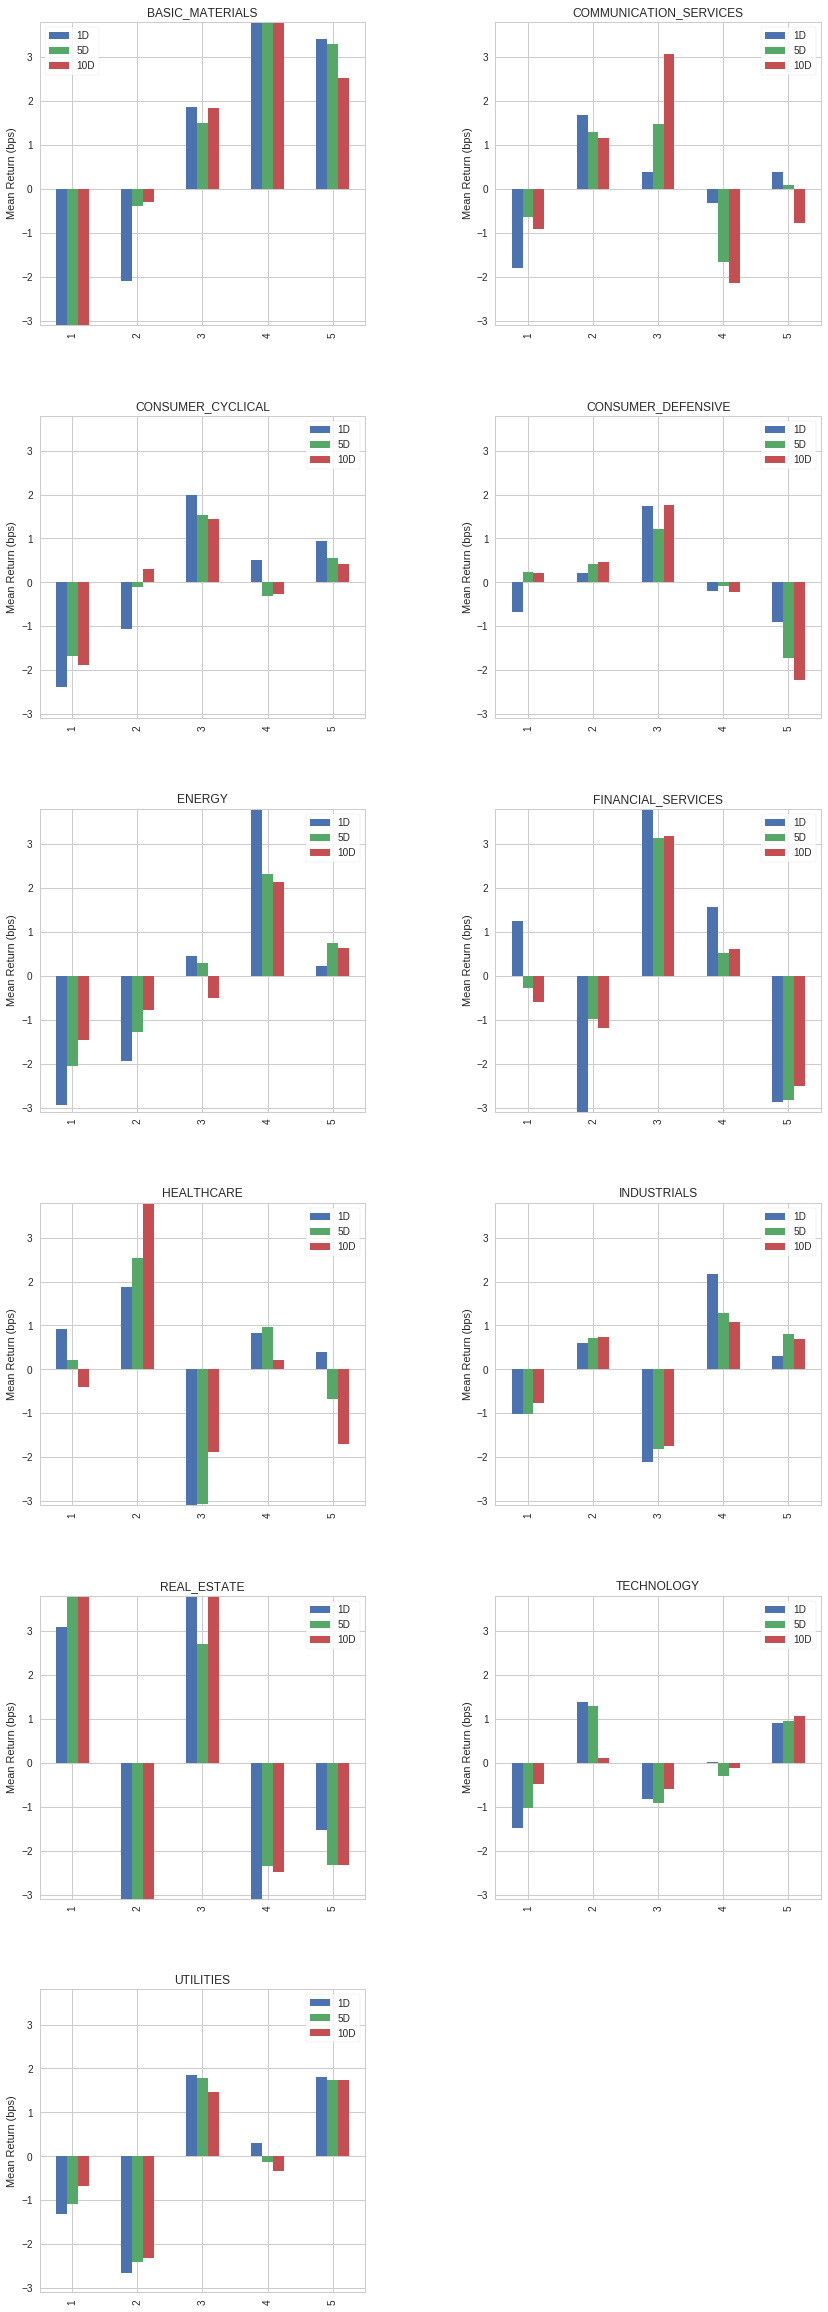

In [ ]:
factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['factor_to_analyze'],
    prices=pricing_data,
    groupby=pipeline_output['sector'],
    groupby_labels=sector_labels,
    binning_by_group=True,
)

create_returns_tear_sheet(factor_data, by_group=True, group_neutral=True)

## Visualizing An Alpha Factor's Decay Rate

A lot of fundamental financial data only comes out 4 times a year in quarterly reports. Because of this low frequency, it can be useful to increase the amount of time `get_clean_factor_and_forward_returns()` looks into the future to calculate returns. 

Note: A month usually has 21 trading days, a quarter usually has 63 trading days, and a year usually has 252 trading days.

Let's say you're creating a strategy that buys stock in companies with rising profits (data that is released every 63 trading days). You have to decide how far to look into the future.

Running the following cell charts the alpha factor's IC mean over time. The point where the line dips below 0 represents when the alpha factor's predictions aren't usefull anymore.

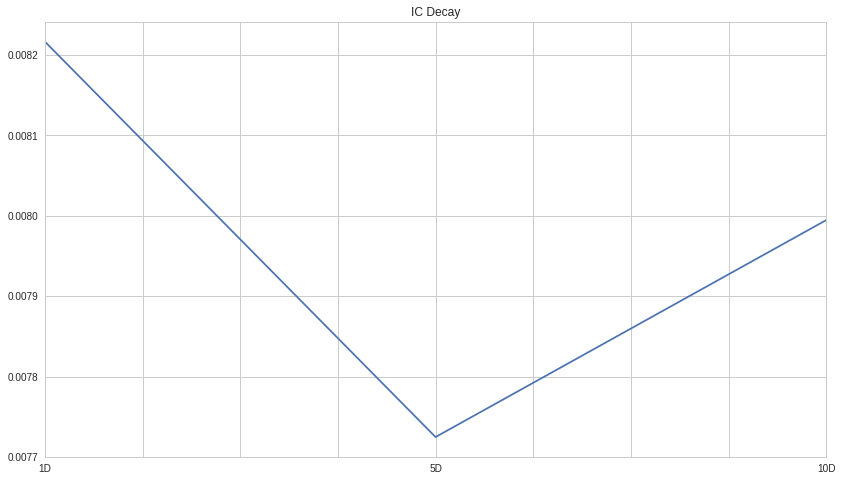

In [ ]:
from alphalens.performance import mean_information_coefficient
mean_information_coefficient(factor_data).plot(title="IC Decay");

Running the code below produces the following error:

image.png


In [ ]:
factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['factor_to_analyze'], 
    pricing_data,
    periods=range(1,252,20) # The third argument to the range statement changes the "step" of the range
)

mean_information_coefficient(factor_data).plot()

## Dealing With MaxLossExceededError

`get_clean_factor_and_forward_returns()` looks at how alpha factor data affects pricing data *in the future*. This means you need pricing data to go further into the future than the alpha factor data **by at least as long as the forward looking period.** 

In this case, `get_pricing()`'s `end_date` is changed to be at least a year after `run_pipeline()`'s `end_date`.

As you can see, this alpha factor's IC decays quickly after a quarter, but recovers and gets better six months into the future.

Dropped 3.3% entries from factor data: 3.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


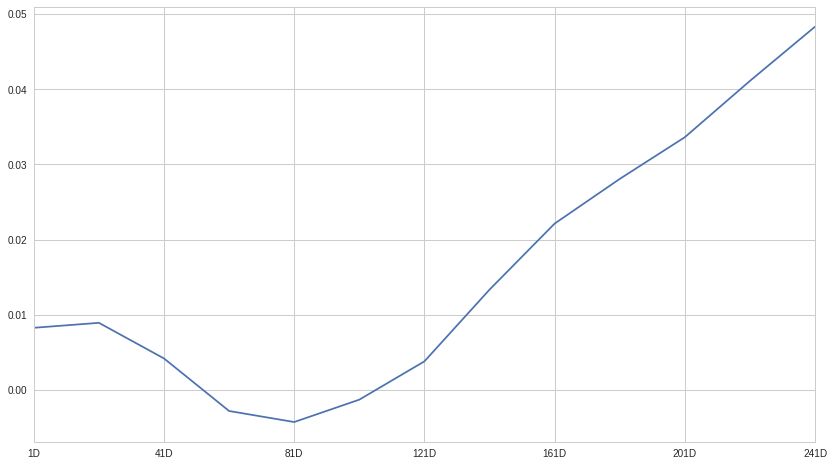

In [ ]:
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date='2013-1-1', 
    end_date='2014-1-1' #  *** NOTE *** Our factor data ends in 2014
)

pricing_data = get_pricing(
    pipeline_output.index.levels[1], 
    start_date='2013-1-1',
    end_date='2015-2-1', # *** NOTE *** Our pricing data ends in 2015
    fields='open_price'
)

factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['factor_to_analyze'], 
    pricing_data,
    periods=range(1,252,20) # Change the step to 10 or more for long look forward periods to save time
)

mean_information_coefficient(factor_data).plot()